In [1]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
import os
from tqdm import tqdm

In [2]:
df0 = pd.read_csv(f"./bt_stock_data/AAL.csv", index_col=0)
bad_tickers = []
for file in tqdm(os.listdir("./bt_stock_data/")):
       df = pd.read_csv(f"./bt_stock_data/{file}", index_col=0)
       if len(df.index) != len(df0.index):
              bad_tickers.append(file[:-4])

100%|███████████████████████████████████████████████████████████████████████████████| 469/469 [00:01<00:00, 296.40it/s]


In [9]:
def alpha_realization(folder):

    df_list = []

    spy_ohlc_df = yf.download('SPY', start='2018-01-01', end='2021-12-31')

    for file in tqdm(os.listdir("./"+ folder + "/")):

        #Load data
        ticker = file[:-4]
        df_feed = pd.read_csv(".\\" + folder + "\\" + str(ticker) +".csv", index_col=0, parse_dates=True)

        #Create signal
        df_feed['signal'] = np.sign(df_feed['transactionAmounts']) * np.where(df_feed['numTransactions'] > 0, 1, 0)

        #Add market data
        df_feed['spy_close'] = spy_ohlc_df['Adj Close']
        df_feed['spy_open'] = spy_ohlc_df['Open']
        
        #Create a 90 day rolling covariance series
        rolling_cov = df_feed[['close','spy_close']].pct_change().rolling(90).cov().reset_index()
        rolling_cov = rolling_cov[rolling_cov['level_1'] == 'close'][['date','spy_close']].set_index('date')

        #beta = 90 day rolling covariance / 90 day rolling market variance
        beta_df = (rolling_cov / df_feed[['spy_close']].pct_change().rolling(90).var()).shift()

        period_array = [1, 2, 3, 4, 5, 10, 20, 60, 120, 180, 250, 360, 500]
        for period in period_array:

            #Compute stock's performance over period long horizon and remove market component
            df_feed['FwdPerf' + str(period)] = df_feed['close'].pct_change(period).shift(-period) \
                - beta_df['spy_close'] * df_feed['spy_close'].pct_change(period).shift(-period)

        if df_feed.shape[0] > 0 and (df_feed.shape[0] == len(df_feed.index.unique())):
            if ticker in ['CRM', 'TECH', 'DLTR', 'V']:
                continue
            if ticker in bad_tickers:
                continue  

            df_list.append(df_feed[['signal'] + ['FwdPerf' + str(period) for period in period_array]])

    complete_df = pd.concat(df_list)

    bias_array = []
    #Compute bias (correlation * sigma_y) for each forward performance period
    for period in period_array:
        subset = complete_df[['signal','FwdPerf'+str(period)]].dropna()
        bias_array.append(sm.OLS(subset['signal'],sm.add_constant(subset['FwdPerf' + str(period)])).fit().params['FwdPerf' + str(period)] * subset['signal'].std())

    return period_array, bias_array

In [10]:
period_array, bias_array_edgar = alpha_realization('bt_stock_data')
_, bias_array_insider          = alpha_realization('bt_stock_data_forward')

[*********************100%***********************]  1 of 1 completed


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:27<00:00, 16.78it/s]


[*********************100%***********************]  1 of 1 completed


100%|████████████████████████████████████████████████████████████████████████████████| 479/479 [00:28<00:00, 16.84it/s]


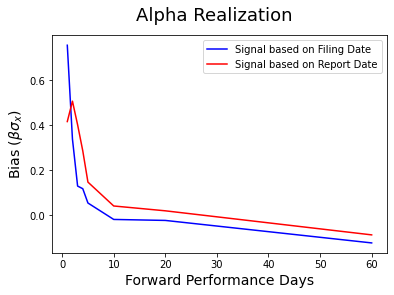

In [11]:
fig = plt.figure()
plt.plot(period_array[:-5], bias_array_edgar[:-5], color = 'blue', label = 'Signal based on Filing Date')
plt.plot(period_array[:-5], bias_array_insider[:-5], color = 'red', label = 'Signal based on Report Date')
fig.suptitle('Alpha Realization', fontsize=18)
plt.xlabel('Forward Performance Days', fontsize=14)
plt.ylabel(r'Bias ($\beta\sigma_x$)', fontsize=14)
plt.legend()

In [6]:
def alpha_realization(folder):

    df_list = []

    spy_ohlc_df = yf.download('SPY', start='2018-01-01', end='2021-12-31')

    for file in tqdm(os.listdir("./"+ folder + "/")):

        #Load data
        ticker = file[:-4]
        df_feed = pd.read_csv(".\\" + folder + "\\" + str(ticker) +".csv", index_col=0, parse_dates=True)

        #Create signal
        df_feed['signal'] = np.sign(df_feed['transactionAmounts']) * np.where(df_feed['numTransactions'] > 0, 1, 0)

        #Add market data
        df_feed['spy_close'] = spy_ohlc_df['Adj Close']
        df_feed['spy_open'] = spy_ohlc_df['Open']
        
        #Create a 90 day rolling covariance series
        rolling_cov = df_feed[['open','spy_open']].pct_change().rolling(90).cov().reset_index()
        rolling_cov = rolling_cov[rolling_cov['level_1'] == 'open'][['date','spy_open']].set_index('date')

        #beta = 90 day rolling covariance / 90 day rolling market variance
        beta_df = (rolling_cov / df_feed[['spy_open']].pct_change().rolling(90).var()).shift()

        period_array = [1, 2, 3, 4, 5, 10, 20, 60, 120, 180, 250, 360, 500]
        for period in period_array:

            #Compute stock's performance over period long horizon and remove market component
            df_feed['FwdPerf' + str(period)] = df_feed['open'].shift(-1).pct_change(period).shift(-period) - \
                beta_df['spy_open'] * df_feed['spy_open'].shift(-1).pct_change(period).shift(-period)

        if df_feed.shape[0] > 0 and (df_feed.shape[0] == len(df_feed.index.unique())):
            if ticker in ['CRM', 'TECH', 'DLTR', 'V']:
                continue
            if ticker in bad_tickers:
                continue  

            df_list.append(df_feed[['signal'] + ['FwdPerf' + str(period) for period in period_array]])

    complete_df = pd.concat(df_list)

    bias_array = []
    #Compute bias (correlation * sigma_y) for each forward performance period
    for period in period_array:
        subset = complete_df[['signal','FwdPerf'+str(period)]].dropna()
        bias_array.append(sm.OLS(subset['signal'],sm.add_constant(subset['FwdPerf' + str(period)])).fit().params['FwdPerf' + str(period)] * subset['signal'].std())

    return period_array, bias_array

In [7]:
period_array, bias_array_edgar = alpha_realization('bt_stock_data')
_, bias_array_insider          = alpha_realization('bt_stock_data_forward')

[*********************100%***********************]  1 of 1 completed


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [01:08<00:00,  6.81it/s]


[*********************100%***********************]  1 of 1 completed


100%|████████████████████████████████████████████████████████████████████████████████| 479/479 [01:10<00:00,  6.80it/s]


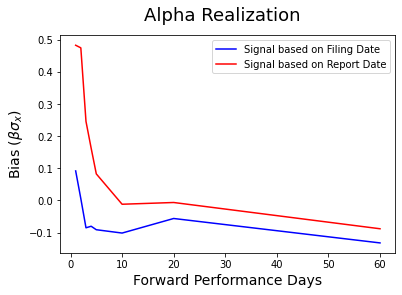

In [8]:
fig = plt.figure()
plt.plot(period_array[:-5], bias_array_edgar[:-5], color = 'blue', label = 'Signal based on Filing Date')
plt.plot(period_array[:-5], bias_array_insider[:-5], color = 'red', label = 'Signal based on Report Date')
fig.suptitle('Alpha Realization', fontsize=18)
plt.xlabel('Forward Performance Days', fontsize=14)
plt.ylabel(r'Bias ($\beta\sigma_x$)', fontsize=14)
plt.legend()

Alpha Realization Plot in BackTesting

In [2]:
x = [1,2,3,5,10,20,40,60]
sharpe_filing = [-0.45, 0.92, 0.66, 0.17, 0.26, 0.29, -0.06, -0.07]
sharpe_report = [-0.45, 0.92, 0.66, 0.16, 0.26, 0.28, -0.06, -0.07]

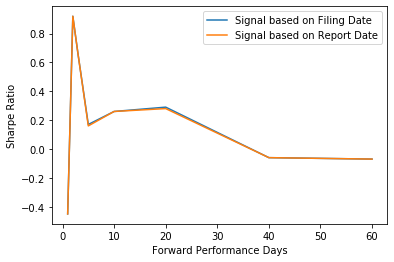

In [3]:
plt.plot(x, sharpe_filing, label='Signal based on Filing Date')
plt.plot(x, sharpe_report, label="Signal based on Report Date")
plt.ylabel("Sharpe Ratio")
plt.xlabel("Forward Performance Days")
plt.legend()